# Image Segmentation on Forest Imagery (Forested and Deforested)

CSC 522 Fall 2024

- Anthony Wu, awu3
- Jheel Gala, jgala	
- Ophelia Sin, oysin
- Venkata Sai Praveen Gunda, vgunda



In [ ]:
### import required packages

import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

In [2]:
# base_dir = 'data'
base_dir = 'data_new'

original_dir = os.path.join(base_dir, 'original')
mask_dir = os.path.join(base_dir, 'mask')


In [3]:
# Load and preprocess original image

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.resize(img, [224, 224])  
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [4]:
# Load mask

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    
    # Decode PNG image, keeping all channels (including alpha)
    mask = tf.image.decode_png(mask, channels=4)  # RGBA (4 channels)

    # Extract the alpha channel (transparency)
    alpha_channel = mask[:, :, 3]  # Alpha channel is the 4th channel

    # Create a binary mask: 1 for opaque (non-transparent), 0 for transparent
    binary_mask = tf.cast(alpha_channel > 0, tf.float32)

    # Resize the binary mask to match (224x224)
    binary_mask = tf.image.resize(binary_mask[..., tf.newaxis], [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return binary_mask

In [5]:
# Function to load both image and mask together
def load_image_and_mask(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_mask(mask_path)
    return image, mask

In [6]:
# Get list of all images and masks
original_paths = sorted([os.path.join(original_dir, fname) for fname in os.listdir(original_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [7]:
# Create TensorFlow Dataset from the file paths of original images and masks
dataset = tf.data.Dataset.from_tensor_slices((original_paths, mask_paths))
print(dataset.element_spec)
buffer_size = 1000
dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(load_image_and_mask)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [8]:
# Split the dataset into training, validation, and test datasets
total_count = len(list(dataset))
train_count = int(0.7 * total_count)
validation_count = int(0.1 * total_count)
test_count = int(0.2 * total_count)


train_dataset = dataset.take(train_count)
remaining = dataset.skip(train_count)
val_dataset = remaining.take(validation_count)
test_dataset = remaining.skip(validation_count)

2024-11-26 18:31:32.041168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.045032: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.051918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.052117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.052308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.064458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.069777: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.078903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:32.082784: W tensorflow/core/lib/png/png_io.cc:89] PNG 

## Prepare for Modeling

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(0.2, seed=seed),
            tf.keras.layers.RandomZoom(0.2, seed=seed)
        ])
        
    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(0.2, seed=seed),
        tf.keras.layers.RandomZoom(0.2, seed=seed)
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [10]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [11]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Prepare the validation dataset without data augmentation
validation_batches = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Prepare the test dataset without data augmentation
test_batches = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [12]:
from tensorflow_examples.models.pix2pix import pix2pix

# Pretrained network
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

In [13]:
# base_model.summary()

## Default Architecture

In [14]:
# Specific layers in MobileNetV2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project'      # 4x4
]

# Get output layers corresponding to the layer names
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create submodel of MobileNetV2 

# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Freezing Weights for Pretrained Model

# ❗️play with the model layers that I want to freeze 
# code would look something like:
# for layer in down_stack.layers[:-23]: # freeze all layers except the last 23
#     layer.trainable = False

down_stack.trainable = False


In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [17]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true,[1, 2, 3]) + tf.reduce_sum(y_pred,[1, 2, 3]) - intersection
    iou = tf.where(
        tf.equal(union, 0),  # Check where the union is zero
        1 - (tf.reduce_sum(y_pred, axis=[1, 2, 3]) / 244**2),  # Special case calculation
        intersection / union  # Regular IoU calculation
    )
    return iou

In [18]:
model.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

### Functions to print results

In [19]:
import matplotlib.pyplot as plt

# Function to display images, ground truth masks, and predicted masks
def display_sample(image, ground_truth, prediction):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')

    plt.show()

In [20]:
# Iterate through the test dataset and display results
def display_results(model, test_dataset, threshold=0.5):
    for images, masks in test_dataset.take(1):
        preds = model.predict(images)
        predicted_masks = (preds>threshold).astype(np.uint8)
        for i in range(len(images)):
            display_sample(images[i].numpy(), masks[i].numpy().squeeze(), predicted_masks[i].squeeze())
            break

### Training with 1-Fold

In [21]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

train_accuracy = history.history['accuracy'][-1]      
train_iou = history.history['iou_metric'][-1]          
train_loss = history.history['loss'][-1]              

val_accuracy = history.history['val_accuracy'][-1]     
val_iou = history.history['val_iou_metric'][-1]       
val_loss = history.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Train IoU: {train_iou:.4f}")
print(f"Train loss: {train_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation IoU: {val_iou:.4f}")
print(f"Validation loss: {val_loss:.4f}")

Epoch 1/30


2024-11-26 18:31:35.120878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.126480: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.127151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.133268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.136648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.141561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.144542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.146802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:35.152753: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2816 - iou_metric: 0.1285 - loss: 0.9683

2024-11-26 18:31:40.424796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.429785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.432855: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.446767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.447805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.454517: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.459053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.464170: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:31:40.467404: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2874 - iou_metric: 0.1326 - loss: 0.9567 - val_accuracy: 0.4087 - val_iou_metric: 0.0889 - val_loss: 0.7429 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.4822 - iou_metric: 0.0774 - loss: 0.7078 - val_accuracy: 0.6764 - val_iou_metric: 0.0696 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6946 - iou_metric: 0.0810 - loss: 0.5643 - val_accuracy: 0.8581 - val_iou_metric: 0.0559 - val_loss: 0.4841 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8330 - iou_metric: 0.0864 - loss: 0.4884 - val_accuracy: 0.8810 - val_iou_metric: 0.0294 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8939 - iou_metric: 0.0539 - loss: 0.3577 - val_accuracy: 0.8839 - val_iou_metric: 0.0322 - val_loss: 0.3628 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

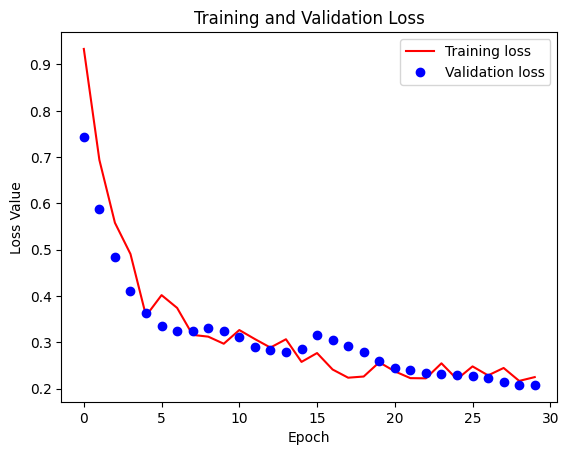

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

#### Predictions

In [23]:
predicted = model.predict(test_batches)

2024-11-26 18:33:23.839659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.845689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.850071: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.858077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.864105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.866115: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.867115: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.869673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:23.873498: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [24]:
predicted_masks = (predicted>0.6).astype(int)

In [25]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - accuracy: 0.9062 - iou_metric: 0.2956 - loss: 0.2587
Test Loss: 0.2587059438228607
Test IOU: 0.2955503761768341
Test Accuracy: 90.62%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


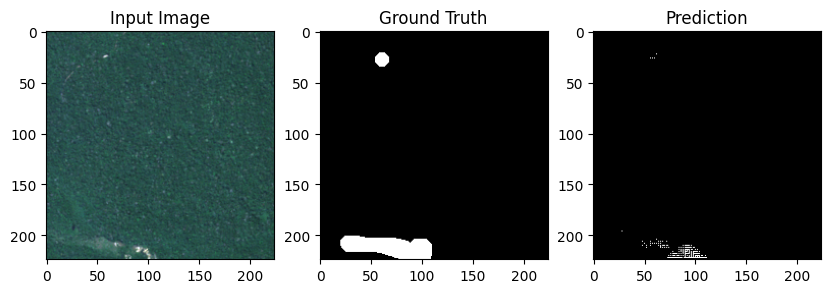

2024-11-26 18:33:26.801503: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
display_results(model, test_batches, threshold=0.6)

## Experimenting with K-Fold Cross Validation

In the following section, we tried 5- and 3-fold cross validation. We found that cross validation doesn't help improve the performance.

### 5-Fold Cross Validation

In [ ]:
k_folds = 5
EPOCHS = 30
BATCH_SIZE = 32
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Concatenate train_dataset and val_dataset to create a full training dataset for K-fold
train_dataset_full = train_dataset.concatenate(val_dataset)


k_fold_results = []
# Loop over each fold
for fold in range(k_folds):
    print(f"Training fold {fold + 1}/{k_folds}...")

    train_dataset_full_copy = train_dataset_full
    # Shard the dataset for training and validation sets
    def get_train_val_datasets(dataset, fold_num, num_folds):

        # Validation set: shard corresponding to this fold number
        val_dataset = dataset.shard(num_shards=num_folds, index=fold_num)
        
        # Training set: all other shards except the current fold number (using filter)
        train_dataset = dataset.enumerate().filter(lambda i, _: i % num_folds != fold_num).map(lambda _, data: data)

        return train_dataset, val_dataset
    
    # Remove index from datasets (if added)
    train_dataset, val_dataset = get_train_val_datasets(train_dataset_full_copy, fold, k_folds)
        
    # Convert lists back to tf.data.Dataset objects
    train_dataset = (train_dataset
        .batch(BATCH_SIZE)
        .cache()
        .shuffle(BUFFER_SIZE)
        .map(Augment())
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model = unet_model(output_channels=1)

    # Compile the model with appropriate loss function and metrics
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou_metric])  

    # Train the model on this fold's training data
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule],
        verbose = 0
    )

    train_accuracy = history.history['accuracy'][-1]      
    train_iou = history.history['iou_metric'][-1]          
    train_loss = history.history['loss'][-1]              

    val_accuracy = history.history['val_accuracy'][-1]     
    val_iou = history.history['val_iou_metric'][-1]       
    val_loss = history.history['val_loss'][-1]            

    k_fold_results.append({
        'fold': fold + 1,
        'train_accuracy': train_accuracy,
        'train_iou': train_iou,
        'train_loss': train_loss,
        'val_accuracy': val_accuracy,
        'val_iou': val_iou,
        'val_loss': val_loss
    })

    print(k_fold_results[-1])

Training fold 1/5...


2024-11-26 18:33:29.568865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.580628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.584443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.586578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.588737: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.595131: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.595548: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.604565: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:33:29.605532: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 1, 'train_accuracy': 0.8279297351837158, 'train_iou': 0.23645669221878052, 'train_loss': 0.3421836495399475, 'val_accuracy': 0.8331174850463867, 'val_iou': 0.2182506024837494, 'val_loss': 0.3665701746940613}
Training fold 2/5...


2024-11-26 18:34:15.145105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.159260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.162490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.169704: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.172652: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.173569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.177308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.179745: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:15.183115: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 2, 'train_accuracy': 0.8193152546882629, 'train_iou': 0.07798158377408981, 'train_loss': 0.38113483786582947, 'val_accuracy': 0.8180509805679321, 'val_iou': 0.19415269792079926, 'val_loss': 0.4441875219345093}
Training fold 3/5...


2024-11-26 18:34:36.618513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.623540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.626297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.631699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.634037: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.634740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.639961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.642460: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:36.647420: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 3, 'train_accuracy': 0.7337802052497864, 'train_iou': 0.06297825276851654, 'train_loss': 0.5203956961631775, 'val_accuracy': 0.8266774415969849, 'val_iou': 0.038322001695632935, 'val_loss': 0.40352028608322144}
Training fold 4/5...


2024-11-26 18:34:58.827070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.830064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.841070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.844393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.846153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.847997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.857566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.864319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:34:58.865511: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 4, 'train_accuracy': 0.8195062875747681, 'train_iou': 0.08998069167137146, 'train_loss': 0.43498480319976807, 'val_accuracy': 0.8489002585411072, 'val_iou': 0.15768545866012573, 'val_loss': 0.3688265383243561}
Training fold 5/5...


2024-11-26 18:35:21.312584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.312611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.313916: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.316544: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.316835: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.317918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.325147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.325385: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:35:21.333512: W tensorflow/core/lib/png/png_io.cc:89] PNG 

{'fold': 5, 'train_accuracy': 0.8054893016815186, 'train_iou': 0.03532710671424866, 'train_loss': 0.3952728509902954, 'val_accuracy': 0.773841381072998, 'val_iou': 0.11472529172897339, 'val_loss': 0.45761746168136597}


In [28]:
for i in k_fold_results:
    print(i)

{'fold': 1, 'train_accuracy': 0.8279297351837158, 'train_iou': 0.23645669221878052, 'train_loss': 0.3421836495399475, 'val_accuracy': 0.8331174850463867, 'val_iou': 0.2182506024837494, 'val_loss': 0.3665701746940613}
{'fold': 2, 'train_accuracy': 0.8193152546882629, 'train_iou': 0.07798158377408981, 'train_loss': 0.38113483786582947, 'val_accuracy': 0.8180509805679321, 'val_iou': 0.19415269792079926, 'val_loss': 0.4441875219345093}
{'fold': 3, 'train_accuracy': 0.7337802052497864, 'train_iou': 0.06297825276851654, 'train_loss': 0.5203956961631775, 'val_accuracy': 0.8266774415969849, 'val_iou': 0.038322001695632935, 'val_loss': 0.40352028608322144}
{'fold': 4, 'train_accuracy': 0.8195062875747681, 'train_iou': 0.08998069167137146, 'train_loss': 0.43498480319976807, 'val_accuracy': 0.8489002585411072, 'val_iou': 0.15768545866012573, 'val_loss': 0.3688265383243561}
{'fold': 5, 'train_accuracy': 0.8054893016815186, 'train_iou': 0.03532710671424866, 'train_loss': 0.3952728509902954, 'val_ac

####  Predictions

In [29]:
test_dataset = (test_dataset
                .batch(BATCH_SIZE)  # Ensure batching
                .prefetch(buffer_size=tf.data.AUTOTUNE))

In [30]:
predicted_k_fold = model.predict(test_batches)
predicted_masks_k_fold = (predicted_k_fold>0.4).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [31]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - accuracy: 0.8826 - iou_metric: 0.1157 - loss: 0.3428
Test Loss: 0.34278732538223267
Test IOU: 0.11566946655511856
Test Accuracy: 88.26%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


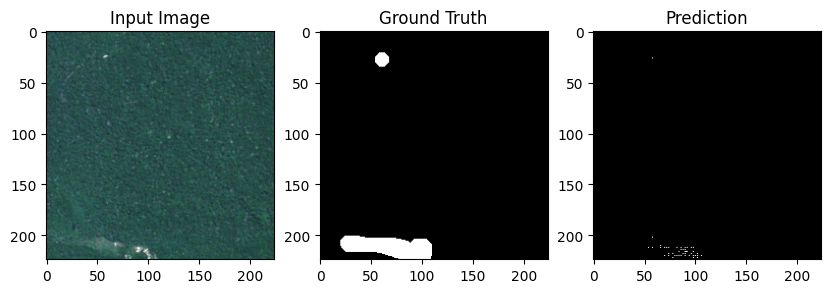

In [32]:
display_results(model, test_batches, threshold=0.6)

### 3-fold Cross Validation

In [66]:
k_folds = 3

results_3_fold = []

# Loop over each fold
for fold in range(k_folds):
    print(f"Training fold {fold + 1}/{k_folds}...")

    train_dataset_full_copy = train_dataset_full

    # Shard the dataset for training and validation sets
    def get_train_val_datasets(dataset, fold_num, num_folds):

        # Validation set: shard corresponding to this fold number
        val_dataset = dataset.shard(num_shards=num_folds, index=fold_num)
        
        # Training set: all other shards except the current fold number (using filter)
        train_dataset = dataset.enumerate().filter(lambda i, _: i % num_folds != fold_num).map(lambda _, data: data)

        return train_dataset, val_dataset
    
    # Remove index from datasets (if added)
    train_dataset, val_dataset = get_train_val_datasets(train_dataset_full_copy, fold, k_folds)
        
    # Convert lists back to tf.data.Dataset objects
    train_dataset = (train_dataset
        .batch(BATCH_SIZE)
        .cache()
        .shuffle(BUFFER_SIZE)
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    val_dataset = (val_dataset
        .batch(BATCH_SIZE)
        .cache()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model_3_fold = unet_model(output_channels=1)

    # Compile the model with appropriate loss function and metrics
    model_3_fold.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou_metric])  

    # Train the model on this fold's training data
    history_3_fold = model_3_fold.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[callback, lr_schedule],
        verbose = 0
    )

    train_accuracy = history_3_fold.history['accuracy'][-1]      
    train_iou = history_3_fold.history['iou_metric'][-1]          
    train_loss = history_3_fold.history['loss'][-1]              

    val_accuracy = history_3_fold.history['val_accuracy'][-1]     
    val_iou = history_3_fold.history['val_iou_metric'][-1]       
    val_loss = history_3_fold.history['val_loss'][-1]            

    results_3_fold.append({
        'fold': fold + 1,
        'train_accuracy': train_accuracy,
        'train_iou': train_iou,
        'train_loss': train_loss,
        'val_accuracy': val_accuracy,
        'val_iou': val_iou,
        'val_loss': val_loss
    })

    print(results_3_fold[-1])

Training fold 1/3...


2024-11-26 18:59:55.199056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.208639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.216972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.219152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.219907: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.223174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.223190: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.224085: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-26 18:59:55.229530: W tensorflow/core/lib/png/png_io.cc:89] PNG 

KeyboardInterrupt: 

In [34]:
for i in results_3_fold:
    print(i)

{'fold': 1, 'train_accuracy': 0.8610082864761353, 'train_iou': 0.22358447313308716, 'train_loss': 0.3372361361980438, 'val_accuracy': 0.8666406869888306, 'val_iou': 0.11059349030256271, 'val_loss': 0.3206159174442291}
{'fold': 2, 'train_accuracy': 0.8397952318191528, 'train_iou': 0.23575259745121002, 'train_loss': 0.38277527689933777, 'val_accuracy': 0.8203698396682739, 'val_iou': 0.10491891950368881, 'val_loss': 0.43824777007102966}
{'fold': 3, 'train_accuracy': 0.8310108184814453, 'train_iou': 0.15643210709095, 'train_loss': 0.42241784930229187, 'val_accuracy': 0.8188389539718628, 'val_iou': 0.06317473202943802, 'val_loss': 0.4597632884979248}


In [65]:
test_loss, test_accuracy, test_iou = model_3_fold.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8754 - iou_metric: 0.0800 - loss: 0.3736
Test Loss: 0.37358909845352173
Test IOU: 0.08000899106264114
Test Accuracy: 87.54%


## Experimenting with unfreezing layers

In the following section, we experimented with unfreezing 1 to 3 depest layers in our encoder to see if that would help improve our accuracy. 

### Final decision: unfreezing 1 layers

In [35]:
# Create submodel of MobileNetV2 
# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack_unfreeze = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

layers_to_unfreeze = ['block_16_project']
for layer in down_stack_unfreeze.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True 
    else:
        layer.trainable = False 

In [36]:
def unet_model_unfreeze(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack_unfreeze(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model_unfreeze=unet_model_unfreeze(output_channels=OUTPUT_CLASSES)

In [37]:
model_unfreeze.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history_unfreeze = model_unfreeze.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4426 - iou_metric: 0.1281 - loss: 1.1558 - val_accuracy: 0.6339 - val_iou_metric: 0.0919 - val_loss: 0.7963 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.6544 - iou_metric: 0.0850 - loss: 0.8036 - val_accuracy: 0.7863 - val_iou_metric: 0.0615 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6827 - iou_metric: 0.0740 - loss: 0.5909 - val_accuracy: 0.8793 - val_iou_metric: 0.0334 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8404 - iou_metric: 0.0367 - loss: 0.4273 - val_accuracy: 0.8811 - val_iou_metric: 0.0026 - val_loss: 0.3487 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.8167 - iou_metric: 0.0012 - loss: 0.4273 - val_accuracy: 0.8812 - val_iou_metric: 1.5896e-04 - val_loss: 0.3444 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━

AttributeError: 'dict' object has no attribute 'history'

In [39]:
train_accuracy_unfreeze = history_unfreeze.history['accuracy'][-1]      
train_iou_unfreeze = history_unfreeze.history['iou_metric'][-1]          
train_loss_unfreeze = history_unfreeze.history['loss'][-1]              

val_accuracy_unfreeze = history_unfreeze.history['val_accuracy'][-1]     
val_iou_unfreeze = history_unfreeze.history['val_iou_metric'][-1]       
val_loss_unfreeze = history_unfreeze.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy_unfreeze:.4f}")
print(f"Train IoU: {train_iou_unfreeze:.4f}")
print(f"Train loss: {train_loss_unfreeze:.4f}")
print(f"Validation accuracy: {val_accuracy_unfreeze:.4f}")
print(f"Validation IoU: {val_iou_unfreeze:.4f}")
print(f"Validation loss: {val_loss_unfreeze:.4f}")

Train accuracy: 0.8238
Train IoU: 0.2031
Train loss: 0.4280
Validation accuracy: 0.8812
Validation IoU: 0.1667
Validation loss: 0.3479


In [40]:
loss_unfreeze = history_unfreeze.history['loss']
val_loss_unfreeze = history_unfreeze.history['val_loss']

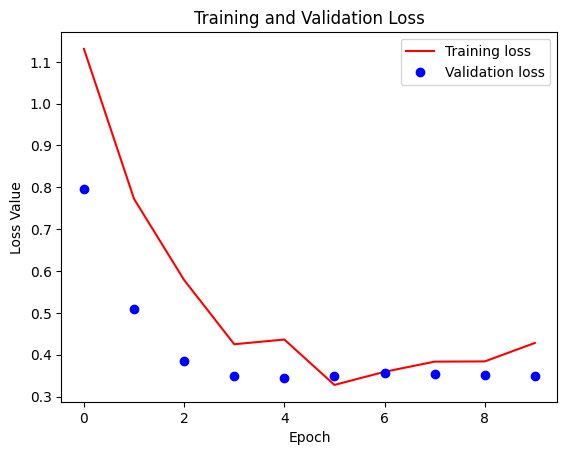

In [41]:
plt.figure()
plt.plot(history_unfreeze.epoch, loss_unfreeze, 'r', label='Training loss')
plt.plot(history_unfreeze.epoch, val_loss_unfreeze, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [42]:
predicted_unfreeze = model_unfreeze.predict(test_batches)
predicted_masks_unfreeze = (predicted_unfreeze>0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [43]:
# Evaluate the model on the test dataset
test_loss_unfreeze, test_accuracys_unfreeze, test_ious_unfreeze = model_unfreeze.evaluate(test_batches)

print(f"Test Loss: {test_loss_unfreeze}")
print(f"Test IOU: {test_ious_unfreeze}")
print(f"Test Accuracy: {test_accuracys_unfreeze * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step - accuracy: 0.8754 - iou_metric: 0.2000 - loss: 0.3689
Test Loss: 0.3688521981239319
Test IOU: 0.2000262588262558
Test Accuracy: 87.54%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


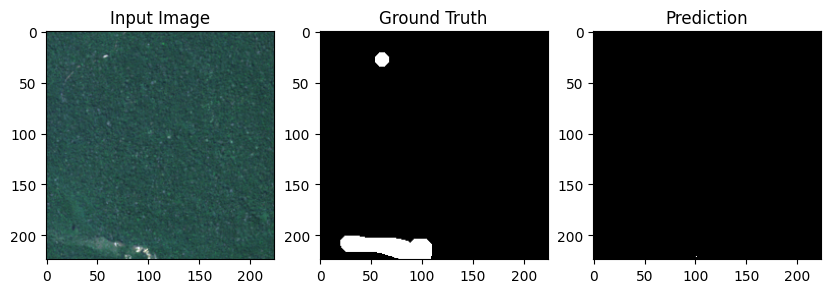

2024-11-26 18:38:38.197782: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
display_results(model_unfreeze, test_batches, threshold=0.5)

### Unfreezing 2 layers

In [45]:
# Create submodel of MobileNetV2 
# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack_unfreeze = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

layers_to_unfreeze = ['block_16_project', 'block_13_expand_relu']
for layer in down_stack_unfreeze.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True 
    else:
        layer.trainable = False 

In [46]:
def unet_model_unfreeze(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack_unfreeze(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model_unfreeze=unet_model_unfreeze(output_channels=OUTPUT_CLASSES)

In [47]:
model_unfreeze.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

In [48]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history_unfreeze = model_unfreeze.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5754 - iou_metric: 0.0791 - loss: 0.6635 - val_accuracy: 0.7089 - val_iou_metric: 0.0595 - val_loss: 0.5161 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6880 - iou_metric: 0.0666 - loss: 0.5098 - val_accuracy: 0.7744 - val_iou_metric: 0.0555 - val_loss: 0.4474 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7276 - iou_metric: 0.0728 - loss: 0.4862 - val_accuracy: 0.8702 - val_iou_metric: 0.0523 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8108 - iou_metric: 0.0627 - loss: 0.4719 - val_accuracy: 0.8846 - val_iou_metric: 0.0232 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8747 - iou_metric: 0.0168 - loss: 0.3761 - val_accuracy: 0.8821 - val_iou_metric: 0.0114 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━

In [49]:
train_accuracy_unfreeze = history_unfreeze.history['accuracy'][-1]      
train_iou_unfreeze = history_unfreeze.history['iou_metric'][-1]          
train_loss_unfreeze = history_unfreeze.history['loss'][-1]              

val_accuracy_unfreeze = history_unfreeze.history['val_accuracy'][-1]     
val_iou_unfreeze = history_unfreeze.history['val_iou_metric'][-1]       
val_loss_unfreeze = history_unfreeze.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy_unfreeze:.4f}")
print(f"Train IoU: {train_iou_unfreeze:.4f}")
print(f"Train loss: {train_loss_unfreeze:.4f}")
print(f"Validation accuracy: {val_accuracy_unfreeze:.4f}")
print(f"Validation IoU: {val_iou_unfreeze:.4f}")
print(f"Validation loss: {val_loss_unfreeze:.4f}")

Train accuracy: 0.9119
Train IoU: 0.3279
Train loss: 0.1816
Validation accuracy: 0.8884
Validation IoU: 0.2436
Validation loss: 0.2056


In [50]:
loss_unfreeze = history_unfreeze.history['loss']
val_loss_unfreeze = history_unfreeze.history['val_loss']

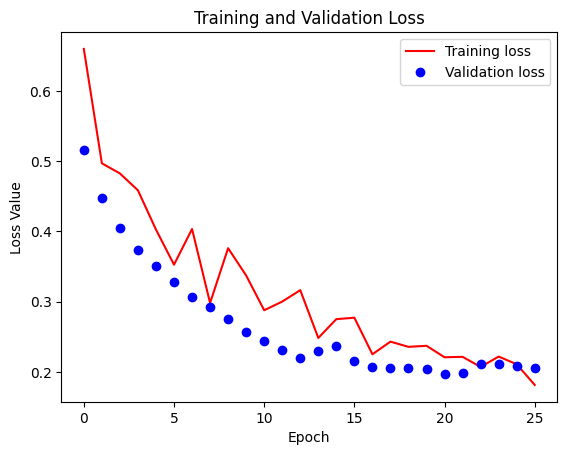

In [51]:
plt.figure()
plt.plot(history_unfreeze.epoch, loss_unfreeze, 'r', label='Training loss')
plt.plot(history_unfreeze.epoch, val_loss_unfreeze, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [52]:
predicted_unfreeze = model_unfreeze.predict(test_batches)
predicted_masks_unfreeze = (predicted_unfreeze>0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [53]:
# Evaluate the model on the test dataset
test_loss_unfreeze, test_accuracys_unfreeze, test_ious_unfreeze = model_unfreeze.evaluate(test_batches)

print(f"Test Loss: {test_loss_unfreeze}")
print(f"Test IOU: {test_ious_unfreeze}")
print(f"Test Accuracy: {test_accuracys_unfreeze * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - accuracy: 0.8810 - iou_metric: 0.1984 - loss: 0.2592
Test Loss: 0.2592432498931885
Test IOU: 0.19836583733558655
Test Accuracy: 88.10%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


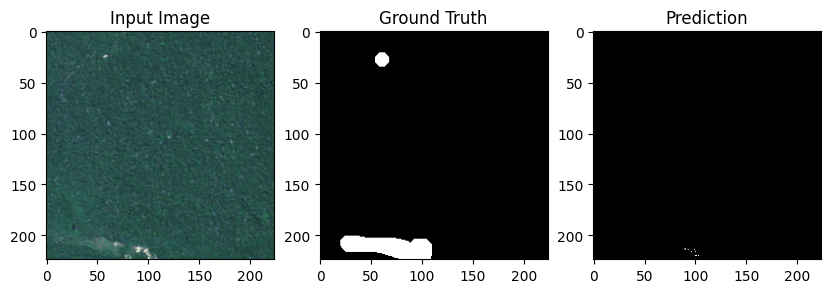

In [54]:
display_results(model_unfreeze, test_batches, threshold=0.5)

### Unfreezing 3 layers

In [55]:
# Create submodel of MobileNetV2 
# Intermediate computations still present in model. These layers are still computing the fetaure maps fro the selected layers.  
down_stack_unfreeze = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

layers_to_unfreeze = ['block_16_project', 'block_13_expand_relu', 'block_6_expand_relu']
for layer in down_stack_unfreeze.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True 
    else:
        layer.trainable = False 

In [56]:
def unet_model_unfreeze(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack_unfreeze(inputs)
  x = skips[-1] # last feature map from the downstack 
  skips = reversed(skips[:-1]) # all the feature maps except the last one are reversed and stored in skips, so that we can use them for skip connections

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model_unfreeze=unet_model_unfreeze(output_channels=OUTPUT_CLASSES)

In [57]:
model_unfreeze.compile(optimizer='adam', #❗️specify learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

In [58]:
EPOCHS = 30
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history_unfreeze = model_unfreeze.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4579 - iou_metric: 0.0986 - loss: 0.8093 - val_accuracy: 0.7942 - val_iou_metric: 0.1326 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7622 - iou_metric: 0.1596 - loss: 0.5423 - val_accuracy: 0.8881 - val_iou_metric: 0.0741 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8553 - iou_metric: 0.1281 - loss: 0.4288 - val_accuracy: 0.8815 - val_iou_metric: 0.0173 - val_loss: 0.3270 - learning_rate: 0.0010
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8575 - iou_metric: 0.0532 - loss: 0.3571 - val_accuracy: 0.8801 - val_iou_metric: 0.0047 - val_loss: 0.3047 - learning_rate: 0.0010
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8573 - iou_metric: 0.0249 - loss: 0.3176 - val_accuracy: 0.8803 - val_iou_metric: 0.0027 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━

In [59]:
train_accuracy_unfreeze = history_unfreeze.history['accuracy'][-1]      
train_iou_unfreeze = history_unfreeze.history['iou_metric'][-1]          
train_loss_unfreeze = history_unfreeze.history['loss'][-1]              

val_accuracy_unfreeze = history_unfreeze.history['val_accuracy'][-1]     
val_iou_unfreeze = history_unfreeze.history['val_iou_metric'][-1]       
val_loss_unfreeze = history_unfreeze.history['val_loss'][-1]     

print(f"Train accuracy: {train_accuracy_unfreeze:.4f}")
print(f"Train IoU: {train_iou_unfreeze:.4f}")
print(f"Train loss: {train_loss_unfreeze:.4f}")
print(f"Validation accuracy: {val_accuracy_unfreeze:.4f}")
print(f"Validation IoU: {val_iou_unfreeze:.4f}")
print(f"Validation loss: {val_loss_unfreeze:.4f}")

Train accuracy: 0.9204
Train IoU: 0.2836
Train loss: 0.1776
Validation accuracy: 0.8942
Validation IoU: 0.1889
Validation loss: 0.1905


In [60]:
loss_unfreeze = history_unfreeze.history['loss']
val_loss_unfreeze = history_unfreeze.history['val_loss']

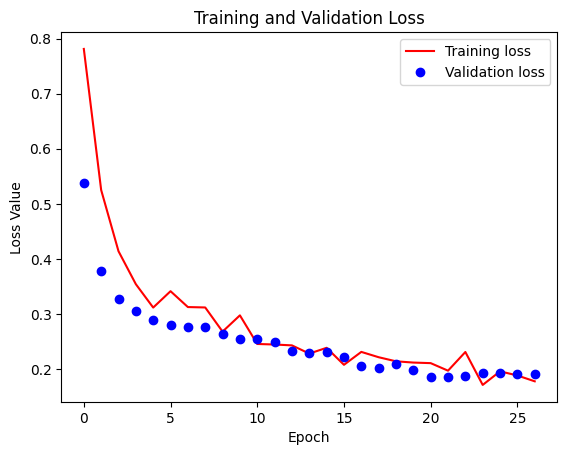

In [61]:
plt.figure()
plt.plot(history_unfreeze.epoch, loss_unfreeze, 'r', label='Training loss')
plt.plot(history_unfreeze.epoch, val_loss_unfreeze, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [62]:
predicted_unfreeze = model_unfreeze.predict(test_batches)
predicted_masks_unfreeze = (predicted_unfreeze>0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [63]:
# Evaluate the model on the test dataset
test_loss_unfreeze, test_accuracys_unfreeze, test_ious_unfreeze = model_unfreeze.evaluate(test_batches)

print(f"Test Loss: {test_loss_unfreeze}")
print(f"Test IOU: {test_ious_unfreeze}")
print(f"Test Accuracy: {test_accuracys_unfreeze * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.8881 - iou_metric: 0.2376 - loss: 0.2316
Test Loss: 0.23159688711166382
Test IOU: 0.2376425862312317
Test Accuracy: 88.81%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


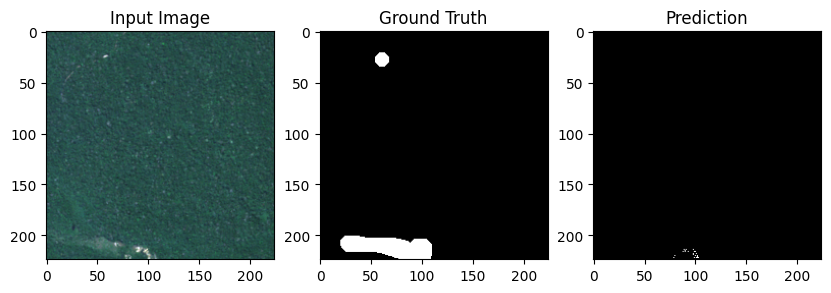

In [64]:
display_results(model_unfreeze, test_batches, threshold=0.4)